# Projet Data Mining

Max length = 2759
Max time = 2757 days 23:00:00


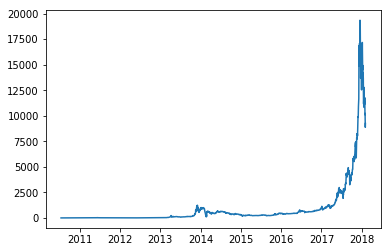

,close,high,low,open,time,volumefrom,volumeto,timestamp
2754,10107.26,11263.70,9871.21,11234.32,1517270400,164072.93,1.720894e+09,2018-01-30
2755,10226.86,10377.96,9698.13,10107.40,1517356800,122260.49,1.230903e+09,2018-01-31
2756,9114.72,10280.84,8726.95,10226.86,1517443200,208918.80,1.964309e+09,2018-02-01
2757,8870.82,9147.93,7786.20,9114.73,1517529600,322596.22,2.768760e+09,2018-02-02
2758,9238.52,9238.52,8194.68,8872.87,1517616000,75208.92,6.560314e+08,2018-02-03


In [1]:
import requests
import datetime
import pandas as pd
import numpy as np 
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

def daily_price_historical(symbol, comparison_symbol, histoday=True, limit=1, aggregate=1, allData='true'):
    # api url
    if histoday:
        url = 'https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym={}&limit={}&aggregate={}&allData={}' \
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate, allData)
    else:
        url = 'https://min-api.cryptocompare.com/data/histohour?fsym={}&tsym={}&limit={}&aggregate={}&allData={}' \
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate, allData)

    # fetch data
    page = requests.get(url)
    data = page.json()['Data']

    # Convert Json to Table
    df = pd.DataFrame(data)

    # add a column with timestamp
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]

    return df


df = daily_price_historical('BTC', 'USD', True)
print('Max length = {}'.format(len(df)))
print('Max time = {}'.format((df.timestamp.max() - df.timestamp.min())))

plt.plot(df.timestamp, df.close)
plt.show()
df['timestamp'] = df['timestamp'].dt.strftime('%Y-%m-%d')
df.tail(5)

In [2]:
df2 = df.set_index('timestamp')
df2.head(7)

,close,high,low,open,time,volumefrom,volumeto
timestamp,,,,,,,
2010-07-17,0.04951,0.04951,0.04951,0.04951,1279324800,20.00,0.9902
2010-07-18,0.08584,0.08585,0.05941,0.04951,1279411200,75.01,5.0900
2010-07-19,0.08080,0.09307,0.07723,0.08584,1279497600,574.00,49.6600
2010-07-20,0.07474,0.08181,0.07426,0.08080,1279584000,262.00,20.5900
2010-07-21,0.07921,0.07921,0.06634,0.07474,1279670400,575.00,42.2600
2010-07-22,0.05050,0.08181,0.05050,0.07921,1279756800,2160.00,129.7800
2010-07-23,0.06262,0.06767,0.05050,0.05050,1279843200,2402.50,141.0700


In [3]:
pa = pd.read_csv('crypto_learning/results.csv', usecols=["Date","Value"])
pa['Date'] = [pd.datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in pa.Date]
pa = pa.set_index('Date')

18


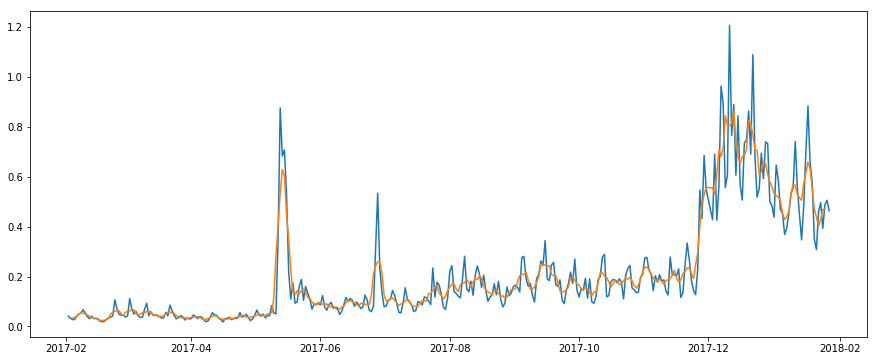

In [4]:
rcParams['figure.figsize'] = 15, 6
pa['mean'] = pa.rolling(window=5, center=True).mean()
ts = pa['mean']

print(np.count_nonzero(abs(ts-pa['Value'])>0.15))

plt.plot(pa)

### Création colonne buzz

In [5]:
pa['buzz']='c'
pa['buzz'][(pa['Value']-ts)>0.15]='u'
pa['buzz'][(pa['Value']-ts)<-0.15]='d'

### Concaténation avec la première table

In [6]:
pa = pa.join(df2)

In [7]:
pa = pa[['open','close','buzz']]

### Affichage des différents buzz/debuzz

In [8]:
pa[pa['buzz']!='c']

,open,close,buzz
Date,,,
2017-05-11,1752.31,1819.29,d
2017-05-13,1686.39,1763.74,u
2017-06-28,2583.75,2577.74,u
2017-11-29,9906.04,9837.86,u
2017-12-04,11244.20,11623.91,u
2017-12-05,11624.37,11667.13,d
2017-12-07,13750.09,16850.31,u
2017-12-08,16867.98,16047.61,u
2017-12-09,16048.18,14843.42,d


### Création de la variable d'ecart

In [9]:
pa['ecart'] = pa['close']-pa['open']

In [10]:
epsilon1 = 0.005
epsilon2 = 0.1
pa['variation'] = 0
pa['variation'][(pa['ecart']>pa['open']*epsilon1) & (pa['ecart']<pa['open']*epsilon2)] = 1
pa['variation'][(pa['ecart']<-pa['open']*epsilon1) & (pa['ecart']>-pa['open']*epsilon2)] = -1
pa['variation'][pa['ecart'] < -pa['open']*epsilon2] = -2
pa['variation'][pa['ecart'] > pa['open']*epsilon2] = 2
pa[abs(pa['variation'])>1]

,open,close,buzz,ecart,variation
Date,,,,,
2017-06-12,2973.45,2656.77,c,-316.68,-2
2017-07-15,2234.17,1975.08,c,-259.09,-2
2017-07-17,1914.09,2233.39,c,319.30,2
2017-07-20,2282.58,2866.02,c,583.44,2
2017-08-05,2878.49,3262.80,c,384.31,2
2017-09-14,3870.29,3243.08,c,-627.21,-2
2017-09-15,3243.08,3713.76,c,470.68,2
2017-09-18,3689.61,4100.28,c,410.67,2
2017-10-12,4824.20,5432.62,c,608.42,2


In [11]:
print(sum(pa['variation']==-2))
print(sum(pa['variation']==-1))
print(sum(pa['variation']==0))
print(sum(pa['variation']==1))
print(sum(pa['variation']==2))

7
112
51
173
15


### Fonctions de création des séquences

In [12]:
def sequences(distance_buzz, liste_variation, liste_buzz) :
    seq1 = [ liste_variation[i-distance_buzz:(i+distance_buzz+1)] 
            for i in range(len(liste_variation[:-(distance_buzz-1)])) 
            if abs(liste_variation[i])==2]
    
    seq2 = [ liste_buzz[i-distance_buzz:(i+distance_buzz+1)] 
            for i in range(len(liste_variation[:-(distance_buzz-1)])) 
            if abs(liste_variation[i])==2]
    
    zipped_list = [list(zip(seq1[i], seq2[i])) for i in range(len(seq1))]
    # zipped_list2 = [[list(a[i]) for i in range(len(a))] for a in zipped_list]
    return zipped_list, zipped_list2

In [ ]:
sequences(3,pa['variation'].tolist(),pa['buzz'].tolist())

In [13]:
def sequ_buzz(taille):
    tab = [[pa['variation'].loc[idx],pa['buzz'].loc[idx]] for idx in pa.index]
    return sequences(taille,tab)

#### On écrit la fonction isSubSeq qui renvoie si la séquence sub est sub-séquence de la séquence seq.

### Fonction de test isSubSeq

In [44]:
def isSubSeq(seq,sub) :
    newsub = list(sub)
    return(SubSeq(seq,newsub))

#### On recherche de manière récursive chaque élément de la sous-séquence dans la séquence principale, tout en avançant dans cette dernière sans retour en arrière. Tant que l'on trouve les éléments on continue la recherche. Si il n'y a plus d'éléments à rechercher, c'est bon et on remonte les appels en renvoyant des True. Si l'un des éléments de la sous-séquence potentielle n'a pas été trouvé, False est renvoyé.

In [182]:
def SubSeq(seq,nè;ewsub,level=0) :
    if(not newsub):
        return True
    first = set(newsub.pop(0))
    for i in range(level,len(seq)) :
        if set(seq[i]).issuperset(first) : 
            return SubSeq(seq,newsub,i+1)
    return False

In [187]:
a={1,2,3}
a.issuperset({1,2})

False

In [148]:
test=[['a'],['b','c'],['a']]
test2=[['c'],['b']]
test3=[['a'],['c']]
print(isSubSeq(test,test2))
isSubSeq(test,test3)

False


True

#### fonction de calcul du  support d'une séquence

In [60]:
def support(dict,tested_seq) :
    return sum(1 for seq in dict if isSubSeq(seq,tested_seq)) 

In [67]:
datatest = [test,test2,test3]
support(datatest,['a','c'])

3

## fonction get_cand

### Premiere fonction de création de candidats de taille k à partir de deux seq de taille k-1

#### Version qui concatène les éléments en bout de séquence :

In [124]:
def generateCandidatesForPair(cand1, cand2):
    cand1Clone = copy.deepcopy(cand1)
    cand2Clone = copy.deepcopy(cand2)
    # drop the leftmost item from cand1:
    if (len (cand1[0]) == 1):
        cand1Clone.pop(0)
    else:
        cand1Clone[0] = cand1Clone[0][1:]
    # drop the rightmost item from cand2:
    if (len (cand2[-1]) == 1):
        cand2Clone.pop(-1)
    else:
        cand2Clone[-1] = cand2Clone[-1][:-1]
    
    # if the result is not the same, then we dont need to join
    if not cand1Clone == cand2Clone:
        return []
    else:
        newCandidate = copy.deepcopy(cand1)
        if (len (cand2[-1]) == 1):
            newCandidate.append(cand2[-1])
        else:
            newCandidate[-1].extend(cand2[-1][-1])
        return newCandidate

In [106]:
def sequenceLength(sequence) : 
    return sum(len(seq) for seq in sequence)

In [ ]:
#### on génère les candidats avec 

In [198]:
def generateCandidates(lastLevelCandidates,focus_val):
    k = sequenceLength(lastLevelCandidates[0]) + 1
    if (k == 2):
        flatShortCandidates = [item for sublist2 in lastLevelCandidates for sublist1 in sublist2 for item in sublist1]
        candidates = [[[a, b]] for a in flatShortCandidates for b in flatShortCandidates if( b > a and (a==focus_val or b==focus_val))]
    else:
        candidates = []
    for i in range(0, len(lastLevelCandidates)):
        for j in range(0, len(lastLevelCandidates)):
            newCand = generateCandidatesForPair(lastLevelCandidates[i], lastLevelCandidates[j])
            if (not newCand == [] and (True in [focus_val in t for t in newCand])):
                candidates.append(newCand)
    candidates.sort()
    return candidates

In [199]:
level_test = [[['a']],[['b']],[['c']],[['d']]]
level_test_2 = generateCandidates(level_test,'a')
print(level_test_2)

[[['a'], ['a']], [['a'], ['b']], [['a'], ['c']], [['a'], ['d']], [['a', 'b']], [['a', 'c']], [['a', 'd']], [['b'], ['a']], [['c'], ['a']], [['d'], ['a']]]


In [190]:
level_test_3 = generateCandidates(level_test_2,'a')
level_test_3

[[['a', 'b']], [['a', 'c']], [['a', 'd']], [['b', 'c']], [['b', 'd']], [['c', 'd']], [['a'], ['a']], [['a'], ['b']], [['a'], ['c']], [['a'], ['d']], [['b'], ['a']], [['b'], ['b']], [['b'], ['c']], [['b'], ['d']], [['c'], ['a']], [['c'], ['b']], [['c'], ['c']], [['c'], ['d']], [['d'], ['a']], [['d'], ['b']], [['d'], ['c']], [['d'], ['d']]]


[[['a'], ['a'], ['a']],
 [['a'], ['a'], ['b']],
 [['a'], ['a'], ['c']],
 [['a'], ['a'], ['d']],
 [['a'], ['a', 'b']],
 [['a'], ['a', 'c']],
 [['a'], ['a', 'd']],
 [['a'], ['b'], ['a']],
 [['a'], ['b'], ['b']],
 [['a'], ['b'], ['c']],
 [['a'], ['b'], ['d']],
 [['a'], ['b', 'c']],
 [['a'], ['b', 'd']],
 [['a'], ['c'], ['a']],
 [['a'], ['c'], ['b']],
 [['a'], ['c'], ['c']],
 [['a'], ['c'], ['d']],
 [['a'], ['c', 'd']],
 [['a'], ['d'], ['a']],
 [['a'], ['d'], ['b']],
 [['a'], ['d'], ['c']],
 [['a'], ['d'], ['d']],
 [['a', 'b'], ['a']],
 [['a', 'b'], ['b']],
 [['a', 'b'], ['c']],
 [['a', 'b'], ['d']],
 [['a', 'b', 'c']],
 [['a', 'b', 'd']],
 [['a', 'c'], ['a']],
 [['a', 'c'], ['b']],
 [['a', 'c'], ['c']],
 [['a', 'c'], ['d']],
 [['a', 'c', 'd']],
 [['a', 'd'], ['a']],
 [['a', 'd'], ['b']],
 [['a', 'd'], ['c']],
 [['a', 'd'], ['d']],
 [['b'], ['a'], ['a']],
 [['b'], ['a'], ['b']],
 [['b'], ['a'], ['c']],
 [['b'], ['a'], ['d']],
 [['b'], ['a', 'b']],
 [['b'], ['a', 'c']],
 [['b'], ['a', 'd']]

#### Versrion qui rajoute les éléments entiers :

In [99]:
import copy
def get_Cand_from_2(cand1, cand2):
    cand1Clone = copy.deepcopy(cand1)
    cand2Clone = copy.deepcopy(cand2)
    print(cand1Clone)
    # drop the leftmost item from cand1:
    cand1Clone.pop(0)
    print(cand1Clone)
    print(cand2Clone)
    # drop the rightmost item from cand2:        
    cand2Clone.pop(-1)
    print(cand2Clone)
    # if the result is not the same, then we dont need to join
    if not cand1Clone == cand2Clone:
        return []
    else:
        newCandidate = copy.deepcopy(cand1)
        newCandidate.append(cand2[-1])
        return newCandidate

In [100]:
test2 = [['b','c'],['a'],['c','b']]
print(test)
print(test2)
print()
get_Cand_from_2(test,test2)

[['a'], ['b', 'c'], ['a']]
[['b', 'c'], ['a'], ['c', 'b']]

[['a'], ['b', 'c'], ['a']]
[['b', 'c'], ['a']]
[['b', 'c'], ['a'], ['c', 'b']]
[['b', 'c'], ['a']]


[['a'], ['b', 'c'], ['a'], ['c', 'b']]

#### fonction get_cand

In [ ]:
def get_cand(prev_level) :
    k = len(prev_level)
    

### tests en cours :

In [20]:
seq_test = sequ_buzz(3)

### Recherche des séquences qui se répètent de taille max

In [15]:
seqtest = sequences(3,ecart)
occmax = 1
tailleseq = 31
while occmax < 2 :
    seqtest = sequences(tailleseq,ecart)
    c = Counter(map(tuple,seqtest))
    c = pd.DataFrame.from_dict(c,orient='index').reset_index()
    c = c.rename(columns = {"index":"sequences",0:"occurences"} )
    c = c.sort_values(by="occurences",ascending=False)
    c = c.reset_index(drop = True)
    c= np.array(c)
    occmax = max(occmax,c[0,1])
    print(occmax)
    tailleseq -= 1
    
print(tailleseq+1)
print(c)
#c[sum(abs(c))>1]

NameError: name 'ecart' is not defined

In [ ]:
seq